In [1]:
# Import external libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
import mplfinance as mpf
import seaborn as sns
from dateutil import parser
import re

# Import utility functions
import util.analysis as a
import util.plot as p

## I Bitcoin Price Analysis

### A Data Loading and Preprocessing
1 Bitcoin dataset is loaded into a pandas DataFrame

In [2]:
# Read raw bitcoin dataset
btc_data = pd.read_csv("data/crytpo_data.csv", index_col = 0)
btc_data.head(3)

,symbol,name,price,dayHigh,dayLow,volume,open,close,timestamp,time
_id,,,,,,,,,,
67477c998ad02b4e72f11b46,BTC,Bitcoin USD,96921.72,96962.00,91804.37,8.124583e+10,91938.32,91938.32,1732738201,2024-11-27 20:10:01.889000
67476e8a722b15343d0157f4,BTC,Bitcoin USD,96078.15,96664.20,91804.37,8.124583e+10,91938.32,91938.32,1732734600,2024-11-27 19:10:02.207000
6747607add19519ca50317d8,BTC,Bitcoin USD,96328.41,96530.48,91804.37,8.124583e+10,91938.32,91938.32,1732731000,2024-11-27 18:10:02.034000


2 Summarize statistics for numerical columns, helping to understand the dataset's range, mean, and standard deviation.

In [55]:
btc_data.describe()

,price,dayHigh,dayLow,volume,open,close,timestamp
count,729.000000,729.000000,729.000000,7.290000e+02,729.000000,729.000000,7.290000e+02
mean,83536.379849,84597.927016,81695.471811,7.108863e+10,82767.179084,82767.179084,1.731428e+09
std,10787.795406,10954.365599,10609.820189,3.269491e+10,10831.622600,10831.622600,7.579677e+05
min,67403.940000,68538.000000,66783.770000,1.819931e+10,67785.195000,67785.195000,1.730132e+09
25%,72306.000000,72714.380000,69705.760000,4.551983e+10,70202.875000,70202.875000,1.730773e+09
50%,87671.530000,89600.000000,85010.000000,6.365704e+10,87305.710000,87305.710000,1.731428e+09
75%,92476.100000,93772.260000,90853.000000,8.930853e+10,91938.320000,91938.320000,1.732083e+09
max,99639.100000,99860.000000,97806.000000,1.698264e+11,99005.305000,99005.305000,1.732738e+09


3 Data is cleaned and also sorted in ascending order. Timestamp is set as the index of the DataFrame, allowing for time-based operations and easier plotting.

In [56]:
# Drop rows with missing values
btc_data = btc_data.dropna()

# Convert the 'timestamp' column to datetime and set it as the index
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'], unit='s')
btc_data = btc_data.set_index('timestamp').sort_index()  # Sort by timestamp in ascending order

### B Visualize Bitcoin Price
1 Visualize Bitcoin price movement by hour. The price is rising pretty quickly in the past 1 month, suggesting great motivation behind it.

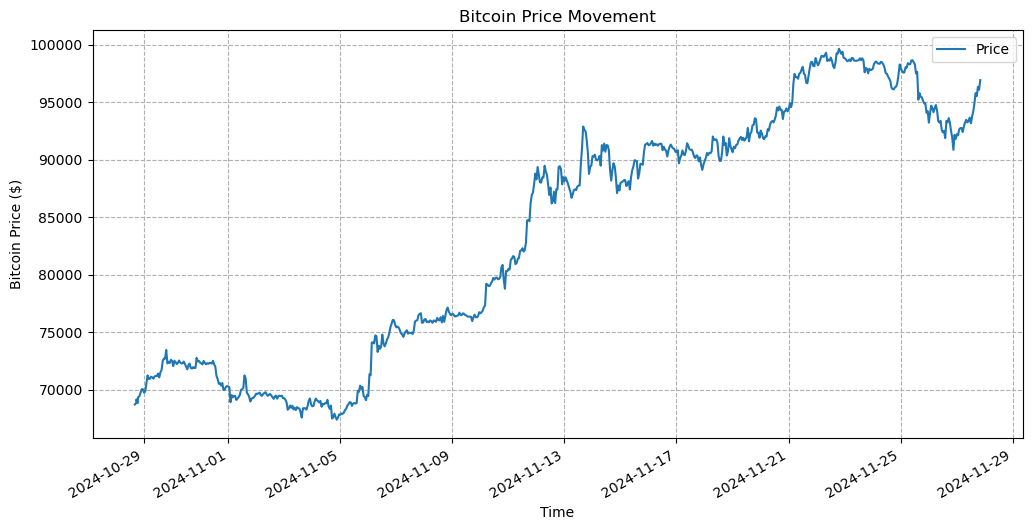

In [57]:
# Plot the Bitcoin price
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data["price"], label="Price")
plt.xlabel('Time')
plt.ylabel('Bitcoin Price ($)')
plt.title('Bitcoin Price Movement')
plt.legend()

# Automatically format the x-axis
plt.gcf().autofmt_xdate()
plt.show()

2 Resample the dataset to 6-hour intervals to reduce granularity and focus on aggregated trends. Calculate all the critical features, including open price, close price, highest price and lowest price and also the trading volume.

In [58]:
# Resample to 6-hour intervals
daily_data = btc_data.resample('6h').agg({
    'open': 'first',
    'price': 'last',
    'dayHigh': 'max',
    'dayLow': 'min',
    'volume': 'sum'
})

In [59]:
# Clean and rename columns for mplfinance
daily_data = daily_data.fillna(method='ffill').dropna()
daily_data = daily_data.rename(columns={
    'price': 'Close',
    'dayHigh': 'High',
    'dayLow': 'Low',
    'open': 'Open',
    'volume': 'Volume'
})

daily_data.head(3)

,Open,Close,High,Low,Volume
timestamp,,,,,
2024-10-28 12:00:00,67939.54,69151.61,69299.0,67532.48,1.169301e+11
2024-10-28 18:00:00,67939.54,70051.00,70288.0,67532.48,1.769670e+11
2024-10-29 00:00:00,67939.54,70965.28,71500.0,67532.48,1.954850e+11


3 Candle Stick Chart generated to reveal the pattern, together with simple moving average (SMA), 5 and also 10 interval prices calculated. 
- A candlestick chart is a type of financial graph, used to describe a given security’s price movements. A single candlestick (typically corresponding to one day, but a different frequency is possible) combines the open, high, low, and close prices.
In the real trading platform, traders use them for identifying patterns and making trading decisions. Candlestick charts convey much more information than a simple line plot of the adjusted close price.
- Green indicates a bullish perspective with the explanation as follows. Red ones are vice versa.
The elements of a bullish candlestick (where the close price in a given time period is higher than the open price):

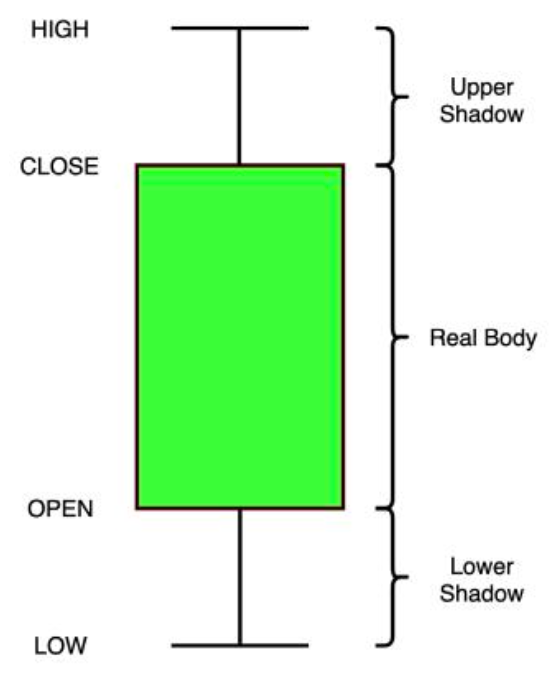

In [163]:
from IPython.display import Image
Image(filename='bullish candle stick.png')

In [60]:
# Add moving averages
daily_data['SMA5'] = daily_data['Close'].rolling(window=5, min_periods=1).mean()
daily_data['SMA10'] = daily_data['Close'].rolling(window=10, min_periods=1).mean()

daily_data.head(3)

,Open,Close,High,Low,Volume,SMA5,SMA10
timestamp,,,,,,,
2024-10-28 12:00:00,67939.54,69151.61,69299.0,67532.48,1.169301e+11,69151.610000,69151.610000
2024-10-28 18:00:00,67939.54,70051.00,70288.0,67532.48,1.769670e+11,69601.305000,69601.305000
2024-10-29 00:00:00,67939.54,70965.28,71500.0,67532.48,1.954850e+11,70055.963333,70055.963333


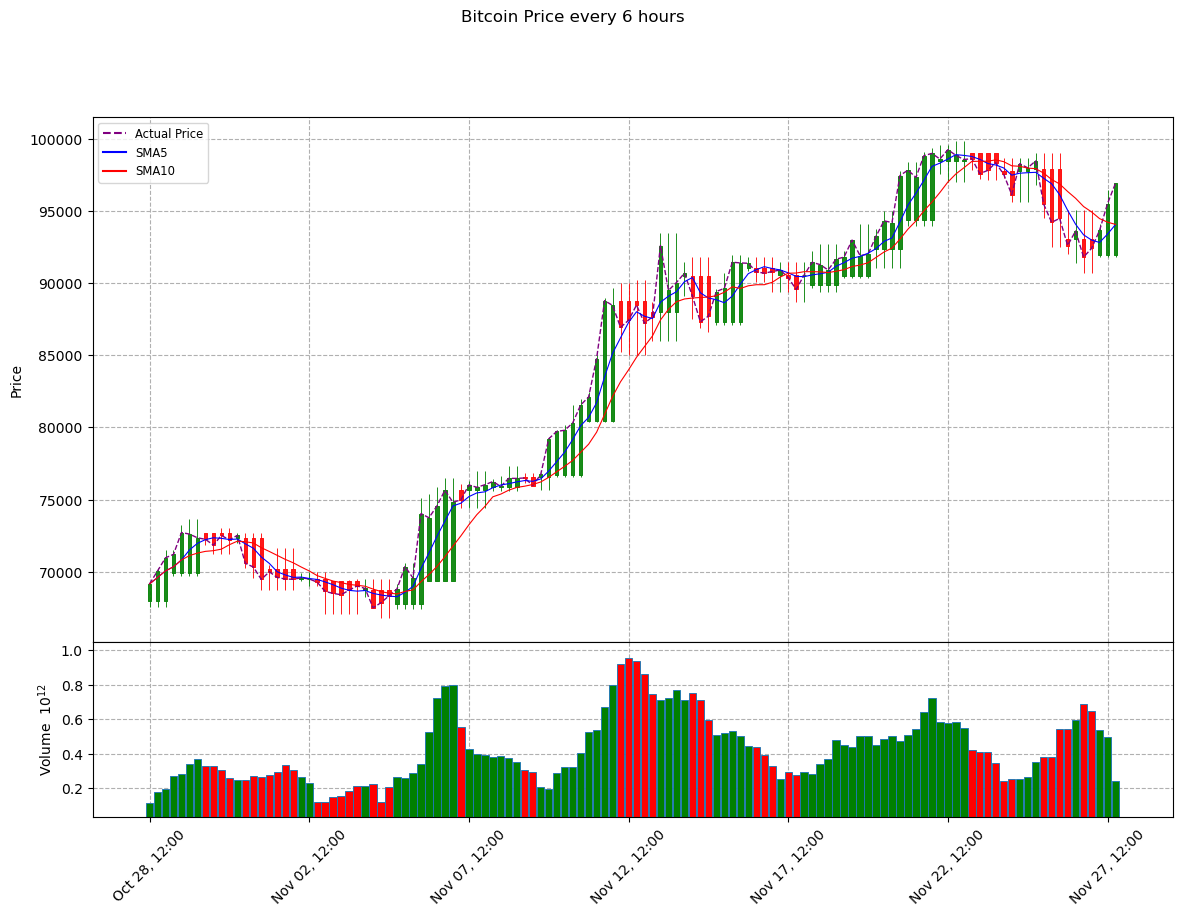

In [61]:
# Create candlestick chart
fig_candle, _ = p.plot_candlestick(daily_data)
plt.show()

### C Return outlier Analysis
While working with any kind of data, we often encounter observations that are significantly different from the majority, that is, outliers. In the financial domain, they can be the result of a wrong price, something major happening in the financial markets, or an error in the data processing pipeline. Many machine learning algorithms and statistical approaches can be heavily influenced by outliers.

Here we use modulization for outlier analysis, where window sizes and the numbers of standard deviations used for creating the thresholds.

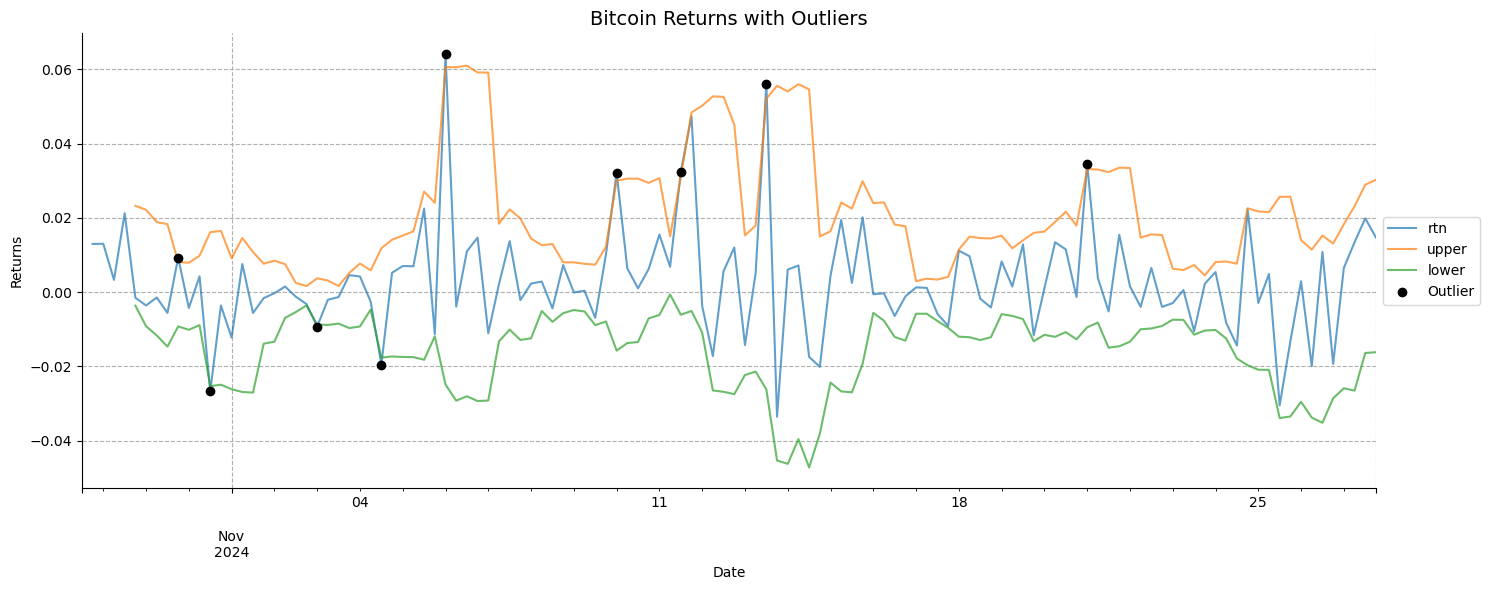

In [168]:
# Analyze returns
returns_analysis = a.analyze_returns(daily_data)
fig_returns, _ = p.plot_returns(returns_analysis)

plt.show()

### D Technical Indicator Analysis
There are hundreds of different technical indicators that traders use for making decisions on whether to enter or exit a position. In this project, we calculate technical indicators based on the TA-Lib library, which include: SMA-5, SMA-10, Bollinger Bands, RSI, MACD and volatility. Here we also modulize the analysis so that different parameters can be input to measure the performance.
- **SMA(Simple moving average)** : 5- and 10-period moving average of the price. A **Doji** occurs when the opening price (open) and closing price (close) are very close or equal while a **Hammer** forms at the bottom of a downtrend, it suggests the potential start of an uptrend. In the past month, we can observe Doji but barely see Hammer, suggesting uptrend without reversal.
- **Bollinger bands** : a statistical method, used for deriving information about the prices and volatility of a certain asset over time. To obtain the Bollinger bands, we calculate the moving average and standard deviation of the time series (prices), using a specified window (5 days and 10days). Then, we set the upper/lower bands at K times the moving standard deviation above/below the moving average. The bands widen with an increase in volatility and contract with a decrease in volatility.
- **RSI(relative strength index)** : an indicator that uses the closing prices of an asset to identify oversold/overbought conditions. Most commonly, the RSI is calculated using a 14-day period and is measured on a scale from 0 to 100 (it is an oscillator). Traders usually buy an asset when it is oversold (if the RSI is below 30) and sell when it is overbought (if the RSI is above 70). 
- **moving average convergence divergence(MACD)** : a momentum indicator showing the relationship between two exponential moving averages (EMA) of a given asset’s price. The MACD line is the difference between the fast (short period) and slow (long period) EMAs. Lastly, we calculate the MACD signal line as a 9-day EMA of the MACD line. Traders can use the crossover of the lines as a trading signal. For example, it can be considered a buy signal when the MACD line crosses the signal line from below.
- **Volatility** : Standard deviation of percentage change over a 10-period window. Bitcoin is among the assets with the largest volatility movement. 

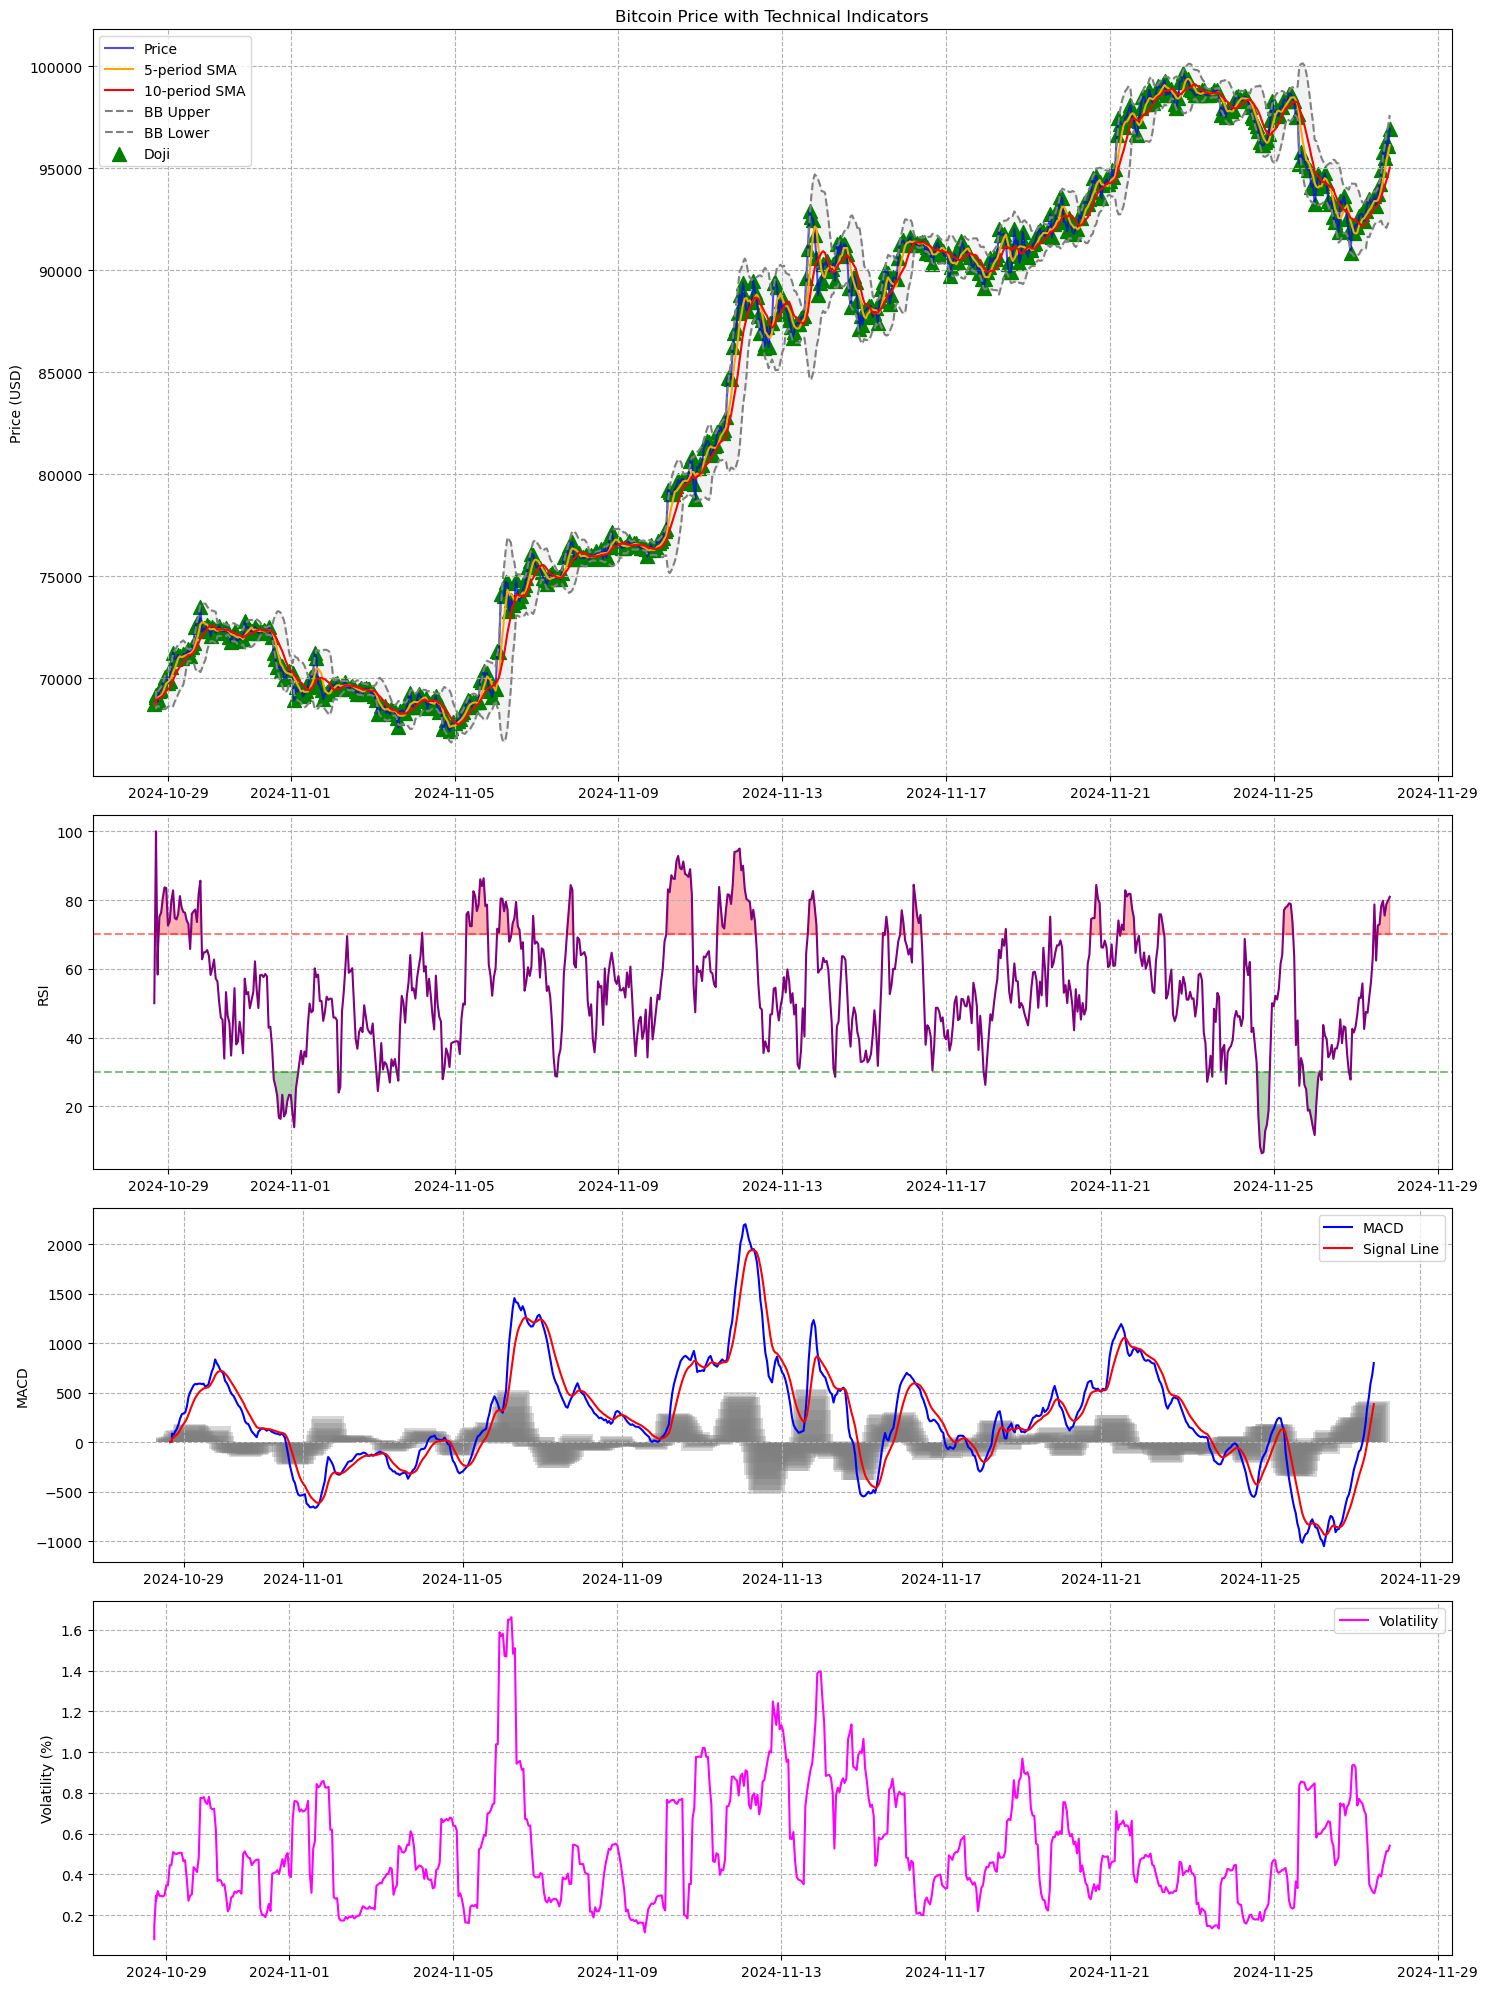

In [169]:
# Example usage
df_with_indicators = a.calculate_technical_indicators(btc_data)

# If you want pattern detection (only if you have OHLC data):
if all(col in btc_data.columns for col in ['open', 'close', 'dayHigh', 'dayLow']):
    df_with_indicators = a.detect_patterns(df_with_indicators)
    fig_technical = p.plot_technical_analysis(df_with_indicators, include_patterns=True)
else:
    fig_technical = p.plot_technical_analysis(df_with_indicators, include_patterns=False)

plt.show()

Here we clear the DataFrame and round timestamps to the nearest hour for the further analysis with Twitter sentiment.

In [ ]:
import numpy as np
import pandas as pd


def analyze_returns(daily_data):
  """Analyze price returns and detect outliers."""
  # Calculate returns
  daily_data['rtn'] = daily_data['Close'].pct_change()
  
  # Calculate rolling statistics
  df_rolling = daily_data[['rtn']].rolling(window=5).agg(["mean", "std"])
  df_rolling.columns = ["mean", "std"]
  df_rolling = df_rolling.dropna()
  
  # Calculate bounds
  N_SIGMAS = 2
  df_rolling["upper"] = df_rolling["mean"] + N_SIGMAS * df_rolling["std"]
  df_rolling["lower"] = df_rolling["mean"] - N_SIGMAS * df_rolling["std"]
  
  # Identify outliers
  analysis_df = daily_data[['rtn']].join(df_rolling, how="left")
  analysis_df["outlier"] = (
      (analysis_df["rtn"] > analysis_df["upper"]) | 
      (analysis_df["rtn"] < analysis_df["lower"])
  )
  
  return analysis_df


def calculate_technical_indicators(df):
    """Calculate technical indicators for the dataset."""
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Moving averages
    df['SMA_5'] = df['price'].rolling(window=5, min_periods=1).mean()
    df['SMA_10'] = df['price'].rolling(window=10, min_periods=1).mean()
    
    # Bollinger Bands
    df['BB_middle'] = df['price'].rolling(window=10, min_periods=1).mean()
    bb_std = df['price'].rolling(window=10, min_periods=1).std()
    df['BB_upper'] = df['BB_middle'] + 2 * bb_std
    df['BB_lower'] = df['BB_middle'] - 2 * bb_std
    
    # RSI
    delta = df['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['RSI'].fillna(50, inplace=True)  # Fill initial NaN values
    
    # MACD
    exp1 = df['price'].ewm(span=12, adjust=False, min_periods=1).mean()
    exp2 = df['price'].ewm(span=26, adjust=False, min_periods=1).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False, min_periods=1).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
    
    # Volatility
    df['volatility'] = df['price'].pct_change().rolling(window=10, min_periods=1).std() * 100
    
    return df


def detect_patterns(df):
    """Detect candlestick patterns."""
    df = df.copy()
    
    # Ensure we have required columns
    required_columns = ['open', 'close', 'dayHigh', 'dayLow']
    if not all(col in df.columns for col in required_columns):
        print("Warning: Missing required columns for pattern detection. Skipping pattern detection.")
        return df
    
    # Doji pattern
    body = abs(df['close'] - df['open'])
    wick = df['dayHigh'] - df['dayLow']
    df['Doji'] = body <= (wick * 0.1)
    
    # Hammer pattern
    upper_wick = df['dayHigh'] - df[['open', 'close']].max(axis=1)
    lower_wick = df[['open', 'close']].min(axis=1) - df['dayLow']
    df['Hammer'] = (lower_wick > (1.5 * body)) & (upper_wick < body)
    
    return df